# Описание проекта: телекоммуникации
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

***Описание услуг***

Оператор предоставляет два основных типа услуг: 

   * Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
   * Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

   * Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
   * Выделенная линия технической поддержки (TechSupport);
   * Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
   * Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

***Описание данных***

Данные состоят из файлов, полученных из разных источников:

    contract_new.csv — информация о договоре;
    personal_new.csv — персональные данные клиента;
    internet_new.csv — информация об интернет-услугах;
    phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

*Таблица contract:*
* customerID — ID абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

*Таблица personal:*
* customerID — ID пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

*Таблица internet:*
* customerID — ID пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

*Таблица phone:*
* customerID — ID пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

## Подготовка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install scikit-learn==1.1.3

In [4]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import phik

from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, roc_curve, roc_auc_score, 
                             accuracy_score, precision_score, 
                             recall_score, confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from phik.report import plot_correlation_matrix
from phik import report

import re
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 110923

In [5]:
# Напишем функцию для изучения датасетов
def analyse (data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(data.head(10))
    display(data.info())
    display(data.describe())

In [6]:
# Откроем файлы и запишем датасеты в переменные contract, personal, internet и phone
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')

In [7]:
analyse(contract)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [8]:
analyse(personal)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
analyse(internet)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7564-GHCVB,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [10]:
analyse(phone)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2995-UPRYS,No
freq,1,3390


***Вывод:***
    
 * Датасет contract содержит 8 столбцов, 7043 строки
 * Датасет personal содержит 5 столбцов, 7043 строки
 * Датасет internet содержит 8 столбцов, 5517 строк
 * Датасет phone содержит 2 столбца, 6361 строку
 
 Отсутствуют пропуски в данных, есть некорректные названия столбцов и некорректный тип данных.

# План

1. Подготовка данных
2. Анализ данных
3. Модель
4. Тестироваие лучшей модели
5. Отчет

 ***Вопросы:***
 
 Вопросов нет

## Анализ данных

In [11]:
# Объединим все таблицы для дальнейшего исследования
data = contract.merge(personal, on = 'customerID', how = 'left')
data = data.merge(phone, on = 'customerID', how = 'left')
data = data.merge(internet, on = 'customerID', how = 'left')

In [12]:
# Переименуем столбцы
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]

In [13]:
analyse(data)

Количество стобцов: 20
Количество строк: 7043


,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,No,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

None

,monthly_charges,senior_citizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


In [14]:
# Выведем количество пропущеных значений
data.isna().sum()

customer_i_d            0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
dtype: int64

In [15]:
# Предположим, что пользователи не пользуются данными услугами или данные не заполнены
data = data.fillna('No')

In [16]:
# Проверим результат
data.isna().sum()

customer_i_d         0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64

In [17]:
# Изменим типы данных
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['end_date'] = pd.to_datetime(data[data['end_date'] != 'No']['end_date'], format='%Y-%m-%d')

data['total_charges'] = pd.to_numeric(data['total_charges'], errors ='coerce')

In [18]:
# Найдем пользователей, которые еще не совершали платежей
data[data['total_charges'].isnull()]

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


In [19]:
# Удалим эти записи
data = data[data['total_charges'].notna()]

In [20]:
# Создадим целевой признак, означающий, что клинет ушел
data['exited'] = np.nan
data.loc[data['end_date'].isna(), 'exited'] = 0
data['exited'] = data['exited'].fillna(1)
data['exited'] = data['exited'].astype('int')

In [21]:
data.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,exited
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,No,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,No,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,0


In [22]:
# Нам известно, что информация о договорах актуальна на 1 февраля 2020
data['end_date'] = data['end_date'].fillna(pd.to_datetime('2020-02-01', format='%Y-%m-%d'))

In [23]:
# Найдем сколько дней пользователь является клиентом компании
data['sum_days'] = (data['end_date'] - data['begin_date']).dt.days

In [24]:
# Удалим пользователей, которыые является клиентами компании менее 1 дня
data = data[data['sum_days'] != 0]

In [25]:
# Удалим избыточные столбцы
data = data.drop(('customer_i_d'), axis=1)
data = data.drop(('begin_date'), axis=1)
data = data.drop(('end_date'), axis=1)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   multiple_lines     7032 non-null   object 
 10  internet_service   7032 non-null   object 
 11  online_security    7032 non-null   object 
 12  online_backup      7032 non-null   object 
 13  device_protection  7032 non-null   object 
 14  tech_support       7032 non-null   object 
 15  streaming_t_v      7032 non-null   object 
 16  streaming_movies   7032 

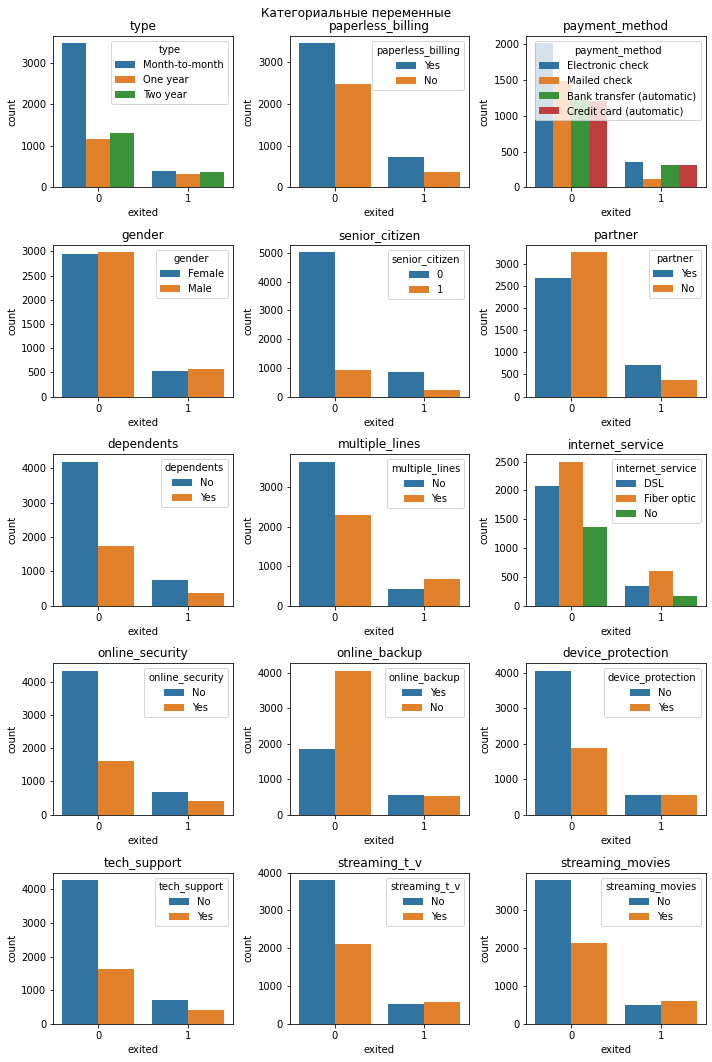

In [27]:
# Построим графики
diagram = data
diagram['senior_citizen'] = diagram['senior_citizen'].astype('object')

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10,15))
fig.suptitle('Категориальные переменные')
axes = axs.ravel()
for  i, column in enumerate(diagram.select_dtypes("object").columns):
    sns.countplot(x='exited', 
                      hue=column, 
                      data=diagram,
                      ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

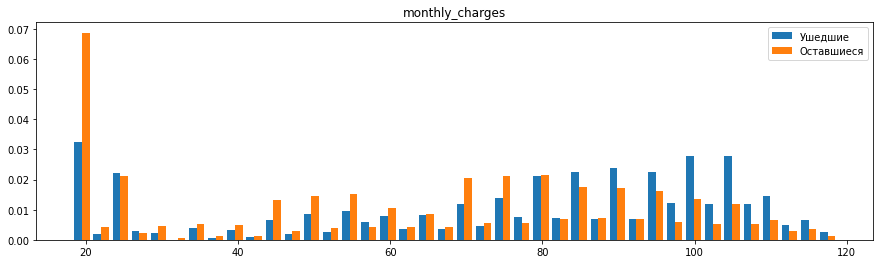

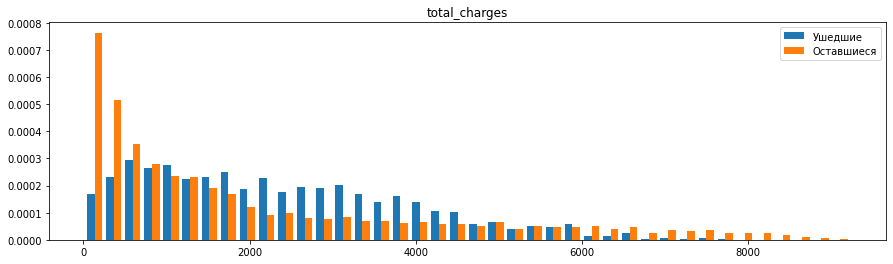

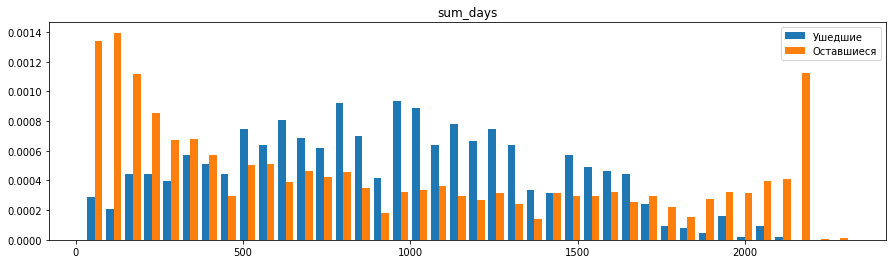

In [28]:
for column in (diagram.drop(['exited'], axis=1).select_dtypes(exclude = "object").columns):
    plt.figure(figsize=(15,4))
    plt.hist([diagram[diagram['exited'] == 1][column], diagram[diagram['exited'] == 0][column]], 
                 label=['Ушедшие', 'Оставшиеся'], 
                 density=True, 
                 bins = 40)
    plt.legend()
    plt.title(column)
    plt.show()

Среди ушедших клиентов:

* большинство абонентов использовали электронные чеки;
* большинство абонентов c ежемесячным платежом 60-100;
* общая оплаченная абонентом сумма чаще всего - меньше 1000;
* большинство абонентов использовали оптоволокно;
* большинство абонентов не использовали такие сервисы как антивирус (device_protection), блокировка небезопасных сайтов (online_security), выделенная линия технической поддержки (tech_support);
* большинство абонентов являлись клиентами менее 100 дней.

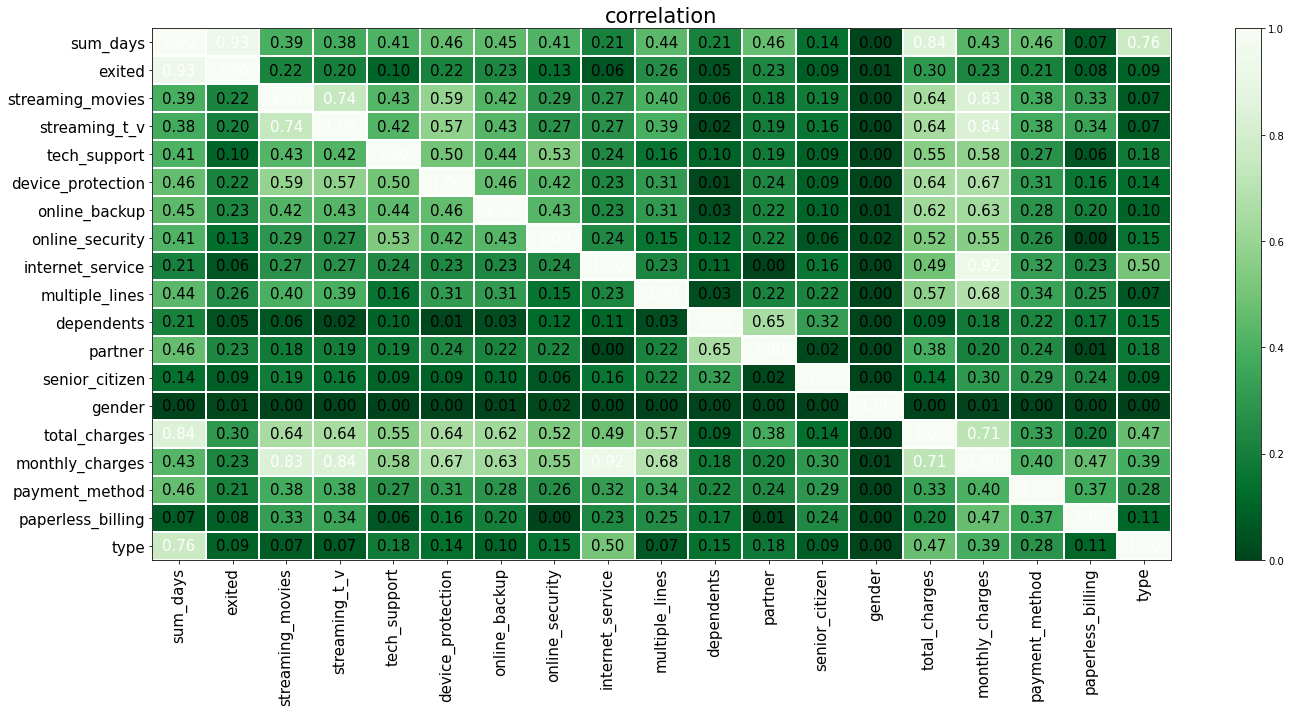

In [29]:
# Проверка данных на мультиколлинеарность
phik_overview = diagram.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'exited', 'delta'])

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens_r", 
                        title="correlation", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

Высокая степень корреляции (больше 0,7) наблюдается между признаками streaming_tv и streaming_movies. В данных для обучения оставим только один признак - streaming_tv.

In [30]:
data = data.drop(columns =['streaming_movies'], axis=1)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   object 
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   multiple_lines     7032 non-null   object 
 10  internet_service   7032 non-null   object 
 11  online_security    7032 non-null   object 
 12  online_backup      7032 non-null   object 
 13  device_protection  7032 non-null   object 
 14  tech_support       7032 non-null   object 
 15  streaming_t_v      7032 non-null   object 
 16  exited             7032 

***Вывод:***

* Датасет data содержит 17 столбцов и 7032 строки.

Выполнена предобработка данных: заполнены пропущенные знвачения, наименования столбцов изменены на корректные. Выделен целевой признак. Построены и проанализированы графики, таблица корреляции. Датасет готов к построению моделей.

## Модель

In [32]:
# Выделим признаки
features = data.drop(['exited'], axis=1)
target = data['exited']

In [33]:
# Разделим датафрейм на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [34]:
# Посмотрим на размерность сформированных наборов данных
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5274, 17)
(1758, 17)
(5274,)
(1758,)


In [35]:
ohe_features = features.select_dtypes("object").columns.to_list()
ohe_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v']

In [36]:
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['monthly_charges', 'total_charges', 'sum_days']

In [37]:
%%time
# RandomForestClassifier

col_transformer_rf = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
                                             (StandardScaler(), num_features), remainder='passthrough')

model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': [250], #range(50, 451, 100),
    'randomforestclassifier__max_depth': range(7, 10),
    'randomforestclassifier__min_samples_split': [3], #(3, 4),
    'randomforestclassifier__min_samples_leaf': [1] #(1, 3)
}

gs_rf = GridSearchCV(
    pipline_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.798 total time=   0.9s
[CV 2/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.805 total time=   0.8s
[CV 3/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.811 total time=   0.8s
[CV 4/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.814 total time=   0.8s
[CV 5/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_le

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'multiple_lines',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          '...
                                                                          'sum_days'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=110923))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(7, 10),
                         'randomforestclassifier__min_samples_leaf': [1],
                         'randomforestclassifier__min_samples_split': [3],
                         'randomforestclassifier__n_estimators': [250]},
             scoring='roc_auc', verbose=3)

In [38]:
rf_best_auc_roc = gs_rf.best_score_
print('Параметры лучшей модели Random Forest: ', gs_rf.best_params_)
print(f"AUC_ROC для модели Random Forest на кросс-валидации: {rf_best_auc_roc:.3f}")

Параметры лучшей модели Random Forest:  {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 250}
AUC_ROC для модели Random Forest на кросс-валидации: 0.812


In [39]:
%%time
# LogisticRegression

col_transformer_lr= make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
                                            (StandardScaler(), num_features), remainder='passthrough')

model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

pipline_lr = make_pipeline(col_transformer_lr, model_lr)

param_grid_lr = {
    'logisticregression__solver': ['lbfgs'], #, 'liblinear'],
    'logisticregression__C': np.arange(0.5, 1.01, 0.1)
}

gs_lr =  GridSearchCV(
    pipline_lr, 
    param_grid=param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=3
)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.734 total time=   0.5s
[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.768 total time=   0.6s
[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.774 total time=   0.7s
[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.774 total time=   0.8s
[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.796 total time=   0.7s
[CV 1/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.734 total time=   0.6s
[CV 2/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.768 total time=   0.7s
[CV 3/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.774 total time=   0.8s
[CV 4/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.774 total

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'multiple_lines',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          '...
                                                                          'tech_support',
                                                                          'streaming_t_v']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'sum_days'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=110923))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logisticregression__solver': ['lbfgs']},
             scoring='roc_auc', verbose=3)

In [40]:
lr_best_auc_roc = gs_lr.best_score_
print('Параметры лучшей модели Logistic Regression: ', gs_lr.best_params_)
print(f"AUC_ROC для модели Logistic Regression на кросс-валидации: {lr_best_auc_roc:.3f}")

Параметры лучшей модели Logistic Regression:  {'logisticregression__C': 0.7, 'logisticregression__solver': 'lbfgs'}
AUC_ROC для модели Logistic Regression на кросс-валидации: 0.769


In [41]:
# CatBoostClassifier

X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

In [42]:
X_train_cb[ohe_features] = X_train_cb[ohe_features].astype('category')
X_test_cb[ohe_features] = X_test_cb[ohe_features].astype('category')

display(X_train_cb.info())
display(X_test_cb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 557 to 4698
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5274 non-null   category
 1   paperless_billing  5274 non-null   category
 2   payment_method     5274 non-null   category
 3   monthly_charges    5274 non-null   float64 
 4   total_charges      5274 non-null   float64 
 5   gender             5274 non-null   category
 6   senior_citizen     5274 non-null   category
 7   partner            5274 non-null   category
 8   dependents         5274 non-null   category
 9   multiple_lines     5274 non-null   category
 10  internet_service   5274 non-null   category
 11  online_security    5274 non-null   category
 12  online_backup      5274 non-null   category
 13  device_protection  5274 non-null   category
 14  tech_support       5274 non-null   category
 15  streaming_t_v      5274 non-null   category
 16  sum_

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 978 to 2559
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               1758 non-null   category
 1   paperless_billing  1758 non-null   category
 2   payment_method     1758 non-null   category
 3   monthly_charges    1758 non-null   float64 
 4   total_charges      1758 non-null   float64 
 5   gender             1758 non-null   category
 6   senior_citizen     1758 non-null   category
 7   partner            1758 non-null   category
 8   dependents         1758 non-null   category
 9   multiple_lines     1758 non-null   category
 10  internet_service   1758 non-null   category
 11  online_security    1758 non-null   category
 12  online_backup      1758 non-null   category
 13  device_protection  1758 non-null   category
 14  tech_support       1758 non-null   category
 15  streaming_t_v      1758 non-null   category
 16  sum_

None

In [43]:
%%time

model_cb = CatBoostClassifier(random_state=RANDOM_STATE, 
                              auto_class_weights='Balanced',
                              cat_features=ohe_features)

param_grid_cb = {
    'max_depth': range(3,5), #range(3,9),
    'learning_rate': [0.1], #[0.005, 0.01, 0.1],
    'n_estimators': range(500, 901, 100)
}

gs_cb =  GridSearchCV(
    model_cb, 
    param_grid=param_grid_cb, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=3
)

gs_cb.fit(X_train_cb, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6672134	total: 51.7ms	remaining: 25.8s
1:	learn: 0.6441444	total: 55.3ms	remaining: 13.8s
2:	learn: 0.6304553	total: 58.7ms	remaining: 9.72s
3:	learn: 0.6172154	total: 62.4ms	remaining: 7.74s
4:	learn: 0.6045933	total: 65.6ms	remaining: 6.5s
5:	learn: 0.5966822	total: 69.4ms	remaining: 5.72s
6:	learn: 0.5903231	total: 72.5ms	remaining: 5.1s
7:	learn: 0.5840383	total: 75.7ms	remaining: 4.66s
8:	learn: 0.5758086	total: 78.9ms	remaining: 4.3s
9:	learn: 0.5696804	total: 82.1ms	remaining: 4.02s
10:	learn: 0.5617667	total: 85.7ms	remaining: 3.81s
11:	learn: 0.5564648	total: 88.6ms	remaining: 3.6s
12:	learn: 0.5525655	total: 91.5ms	remaining: 3.43s
13:	learn: 0.5476528	total: 94.8ms	remaining: 3.29s
14:	learn: 0.5413063	total: 98.1ms	remaining: 3.17s
15:	learn: 0.5362459	total: 102ms	remaining: 3.08s
16:	learn: 0.5323792	total: 106ms	remaining: 3s
17:	learn: 0.5286244	total: 109ms	remaining: 2.92s
18:	learn: 0.5271690	to

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f0d0a74f790>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': range(3, 5),
                         'n_estimators': range(500, 901, 100)},
             scoring='roc_auc', verbose=3)

In [44]:
cb_best_auc_roc = gs_cb.best_score_
print('Параметры лучшей модели CatBoostClassifier: ', gs_cb.best_params_)
print(f"AUC_ROC для модели CatBoostClassifier на кросс-валидации: {cb_best_auc_roc:.3f}")

Параметры лучшей модели CatBoostClassifier:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 900}
AUC_ROC для модели CatBoostClassifier на кросс-валидации: 0.904


***Вывод:***

Лучший результат из трех протестированных моделей показала модель CatBoostClassifier. Значение AUC_ROC = 0.904.

## Тестирование лучшей модели

In [45]:
# Результаты лучшей модели на тесте
model_results = {}

best_model = gs_cb
y_pred = best_model.predict(X_test_cb)

model_results['AUC-ROC'] = roc_auc_score(y_test, best_model.predict_proba(X_test_cb)[:,1])
model_results['precision'] = precision_score(y_test, y_pred)
model_results['recall'] = recall_score(y_test, y_pred)
model_results['accuracy'] = accuracy_score(y_test, y_pred)
model_results

{'AUC-ROC': 0.9202060250344374,
 'precision': 0.6,
 'recall': 0.7314487632508834,
 'accuracy': 0.8782707622298066}

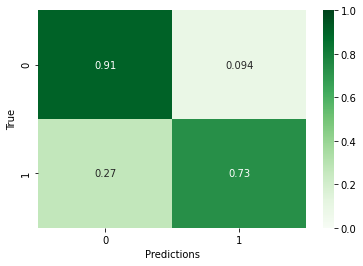

In [46]:
# Матрица ошибок

cfm = {}
cfm = confusion_matrix(y_test, y_pred, normalize='true')

sns.heatmap(pd.DataFrame(cfm), 
            annot=True, 
            cmap='Greens', 
            vmin=0, 
            vmax=1)
plt.xlabel('Predictions')
plt.ylabel('True')
plt.show()

Модель CatBoostClassifier хорошо предсказывает отрицательный класс (клиент остался). 
* Истинно-отрицательные ответы - 0.87

Немного хуже предсказывает положительный класс (клиент ушел).
* Истинно-положительные предсказания - 0.82

In [47]:
# Исследование важности признаков
feat_import = pd.DataFrame(data = {'feature': X_train.columns, 
                                   'percent': best_model.best_estimator_.feature_importances_})
feat_import.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,sum_days,53.240092
1,total_charges,12.268927
2,monthly_charges,10.374521
3,type,6.425575
4,payment_method,3.741161
5,partner,2.382830
6,internet_service,2.147900
7,multiple_lines,1.566845
8,online_backup,1.530905
9,paperless_billing,1.115884


Наибольший вклад вносят признаки:

* sum_days - сколько дней абонент является клиентом компании;
* total_charges - общие расходы абонента;
* monthly_charges - расходы за месяц;
* type - тип оплаты: раз в год-два или ежемесячно;
* internet_service - тип подключения.

***Вывод:***

Выполнено тестирование лучшей модели - CatBoostClassifier:

* 'AUC-ROC': 0.9202060250344374,
* 'precision': 0.6,
* 'recall': 0.7314487632508834,
* 'accuracy': 0.8782707622298066

## Отчет

# Отток клиентов оператора связи

***О компании:*** 

«Ниединогоразрыва.ком» - оператор связи, предоставляет два основных типа услуг: стационарную телефонную связь и интернет. Подключение к интернету может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic). Также доступны такие услуги как: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity), выделенная линия технической поддержки (TechSupport), облачное хранилище файлов для резервного копирования данных (OnlineBackup), стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

***Цель проекта:***

Построить прототип модели машинного обучения, которая сможет прогнозировать уход клиентов из компании.

***Исходные данные:***

Информация о договорах актуальна на 1 февраля 2020. Исходные данные содержатся в 4 датасетах:

* информация о договоре;
* персональные данные клиентов;
* информация об интернет-услугах;
* информация об услугах телефонии.

***Требования к модели:***

* Выбрана метрика AUC-ROC. 
* Значение метрики AUC-ROC не менее 0.85 на тестовых данных.

***Ход проекта:***

Проект был выполнен полностью в соответствии с исходным планом работ.

1. Подготовка данных

На данном этапе импортированы основные библиотеки, необходимые для работы. Написана функуия для изучения датасетов. Датасеты загружены из файлов и записаны в переменные contract, personal, internet и phone. Данные подготовлены и изучены:

 * Датасет contract содержит 8 столбцов, 7043 строки
 * Датасет personal содержит 5 столбцов, 7043 строки
 * Датасет internet содержит 8 столбцов, 5517 строк
 * Датасет phone содержит 2 столбца, 6361 строку
 
Отсутствуют пропуски в данных, есть некорректные названия столбцов и некорректный тип данных.

2. Анализ данных

На данном этапе все таблицы объеденены для дальнейшего исследования, наименования столбцов изменены на корректные. Выполнена предобработка данных: заполнены пропущенные значения, изменен тип данных на корректный, удалены ненужные записи.
Создан целевой признак, означающий, что клинет ушел. Удалены избыточные столбцы. Построены графики, таблица корреляции. В результате анализа данных удалось определить, что среди ушедших клиентов:

* большинство абонентов использовали электронные чеки;
* большинство абонентов c ежемесячным платежом 60-100;
* общая оплаченная абонентом сумма чаще всего - меньше 1000;
* большинство абонентов использовали оптоволокно;
* большинство абонентов не использовали такие сервисы как антивирус (device_protection), блокировка небезопасных сайтов (online_security), выделенная линия технической поддержки (tech_support);
* большинство абонентов являлись клиентами менее 100 дней.

Данные проверены на мультиколлинеарность, удален еще один столбец.

* Датасет data содержит 17 столбцов и 7032 строки.

Датасет готов к построению моделей.

3. Модель

Из набора признаков для обучения модели исключили:

* customer_i_d;
* begin_date;
* end_date;
* streaming_movies.

Набор признаков для обучения.

Категоральные:

* payment_method;
* gender;
* senior_citizen;
* partner;
* dependents;
* internet_service;
* online_security;
* online_backup;
* device_protection;
* tech_support;
* streaming_t_v;
* multiple_lines.

Численные:

* monthly_charges;
* total_charges;
* sum_days.

На данном этапе обучены три модели:

* Случайный лес. Для данной модели категориальные признаки закодировали при помощи OneHotEncoder, численные признаки стандартизировали при помощи StandardScaler. При подборе гиперпараметров использовали GridSearchCV.
* Логистическая регрессия. Для данной модели категориальные признаки закодировали при помощи OneHotEncoder, численные признаки стандартизировали при помощи StandardScaler. При подборе гиперпараметров использовали GridSearchCV.
* CatBoostClassifier. Для данной модели категориальным признакам поменяли тип данных с object на category. При подборе гиперпараметров использовали GridSearchCV.

4. Тестирование лучшей модели

Лучший показатель AUC-ROC на обучающей выборке имеет CatBoostClassifier. Модель имеет следующие гиперапраметры:

* learning_rate: 0.1;
* max_depth: 4;
* n_estimators: 900.

Исследована важность признаков. Наибольший вклад вносят признаки:

* sum_days - сколько дней абонент является клиентом компании;
* total_charges - общие расходы абонента;
* monthly_charges - расходы за месяц;
* type - тип оплаты: раз в год-два или ежемесячно;
* internet_service - тип подключения.

При проверке качества модели на тестовых данных (25% от исходного датасета) выбранная модель имеет AUC-ROC = 0.92, что больше установленного заказчиком порога (0.85).

* 'AUC-ROC': 0.9202060250344374,
* 'precision': 0.6,
* 'recall': 0.7314487632508834,
* 'accuracy': 0.8782707622298066

***Вывод:***

В результате выполнения работы удалось достичь поставленной цели, построен прототип модели машинного обучения, который прогнозирует уход клиентов из компании. Модель имеет AUC-ROC = 0.92, что больше установленного заказчиком порога AUC-ROC не менее 0.85.